# Example usage of adaptive frequency refining for Fourier integration

This notebook demonstrates how `neffint.improve_frequency_range` and `neffint.fourier_integral_adaptive` can be used to adaptively improve a frequency range before using that frequency range to calculate a Fourier integral (using `neffint.fourier_integral_fixed_sampling`).

The adaptive algorithm revolves around making an interpolating polynomial with the current set of frequencies, comparing this interpolation with the true function values at the midpoints between the frequencies, and using Simpson's method to approximate the integrated interpolation error. The midpoint of the interval with the highest interpolated error is then added to the frequency array, and the process starts over. New frequencies are added until the iteration limit is reached or the total integrated interpolation error falls below the tolerance.

It should be noted, and it will be shown, that the algorithm is best suited to improve an already good estimate of a frequency array that captures the important features of the function to be integrated.

#### Do imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike

import neffint as nft

#### Define some functions to measure error

This is mainly for plotting later

In [2]:
def relative_diff(x: float, y: float) -> float:
    """Relative difference"""
    if max(abs(x), abs(y)) == 0:
        return 0
    return abs(x-y)/max(abs(x), abs(y))
relative_diff = np.vectorize(relative_diff)

def absolute_diff(x: ArrayLike, y: ArrayLike):
    """Absolute difference"""
    return np.abs(x-y)

#### Define a function

Here, we choose a function where we know analytically what the Fourier integral is, for testing purposes. Of course, in a real setting, one would choose a function without any analytically known Fourier integral.

In [3]:
def inv_sqrt(f: ArrayLike) -> ArrayLike:
    return 1 / np.sqrt(2*np.pi*f)

# The analytic fourier integral of inv_sqrt
def inv_sqrt_analytic_integral(t: ArrayLike):
    return np.sqrt(np.pi / (2 * t))

#### Define frequencies and times
Define a sorted array of frequencies as a starting point for the algorithm. It is possible to do as is done here and only provide two frequencies, and still get decent results. It is however *recommended* to follow the following two guidelines when giving an initial frequency array:
1. **Make sure all important features of the function are within the endpoints of your array**. The algorithm does a simple scan to higher and lower frequencies, but it is better at adding helpful points to the interior of the initial range.
2. **Try to supply a good initial guess of frequencies** that capture the important features of the function. The algorithm starts with doing a rough scan to search for features, then gradually hones in on a finer mesh around the features it finds. However, if there is too much space between the points in the starting array, the rough scan might miss important features.

Examples of the effect of these guidelines will be showed below.

It is possible to include `-np.inf`, `0` and/or `np.inf` in the frequency range. In the case of infinities, the algorithm will add progressively lower/higher frequencies until the tolerance is reached. When using infinities, some discretion is recommended, as for some functions and parameters, the algorithm may prioritize going towards the infinity at the expense of refining the interior of the range of finite frequencies.

Also define the times you want to compute the integral for. The times can be selected independently of frequency, and can take any finite value (they do not have to be evenly spaced).

In [4]:
# Here we only give 2 frequencies
# In doing so, we break with the second guideline
# We still try to follow the first guideline by having the frequencies span a huge range.
initial_frequencies = (1e-20, 1e20)

times = np.logspace(-15, 0, 100)

#### Define interpolation error norm

A function must be provided that reduces the output interpolation error down to 1D (only the frequency dimension), and applies some error metric. For functions with 1D outputs, this will most often just be the absolute difference between the function and the interpolant. For multidimensional outputs, it might for example be the rms error at each frequency, the maximum error at each frequency, or some weighted average.

In [5]:
interpolation_error_norm = lambda func_output, interpolant_output: np.abs(func_output - interpolant_output)

Just as an example, if (say) the function to be transformed had the signature $f : \reals \rightarrow \reals^4$, running the function on a frequency array of size `N` yields a `func_output` array of shape `(N, 4)`. The algorithm will also make an interpolant array of the same size. The error metric function must take in these two arrays and produce an array of shape `(N,)` (i.e. 1D).

If you wanted to use the rms error, it would look something like this:

```python
# Long version
def interpolation_error_metric(func_output, interpolant_output):
    error = interpolant_output - func_output
    squared_error = error**2
    mean_squared_error = np.mean(squared_error, axis=1) # This stage changes the shape from (N, 4) to # (N,)
    rms_error = np.sqrt(mean_squared_error)
    return rms_error

# Short version
interp_err_metric = lambda func_output, interpolant_output: np.sqrt(np.mean((func_output - interpolant_output)**2, axis=1))
```

#### Use adaptive algorithm to compute fourier integral
This should take up to 10 s.

In [6]:
frequencies, func_arr = nft.improve_frequency_range(
    initial_frequencies=initial_frequencies,
    func=inv_sqrt,
    interpolation_error_norm=interpolation_error_norm,
    absolute_integral_tolerance=1e0, # The absolute tolerance the algorithm tries to get the error below
    step_towards_inf_factor=2, # The multiplicative step size used to scan for higher and lower frequencies to add
    bisection_mode_condition=None, # None (the default) here gives only logarithmic bisection when adding internal points
    max_iterations=10000,
)

transform_arr = nft.fourier_integral_fixed_sampling(
    times=times,
    frequencies=frequencies,
    func_values=func_arr,
    pos_inf_correction_term=True,
    neg_inf_correction_term=False,
    interpolation="pchip"
)

# The two steps above are also combined into the function fourier_integral_adaptive, if one is not interested in the frequencies and func_values used for the Fourier integral itself.
# There is no difference in run time between running the two functions separately or the combined function.

# Also make an array of the analytically expected values, for comparison
transform_arr_analytic = inv_sqrt_analytic_integral(times)

#### Check out the intermediate results

The final number of frequencies: 8515, spanning from 1e-20 to 1e+20


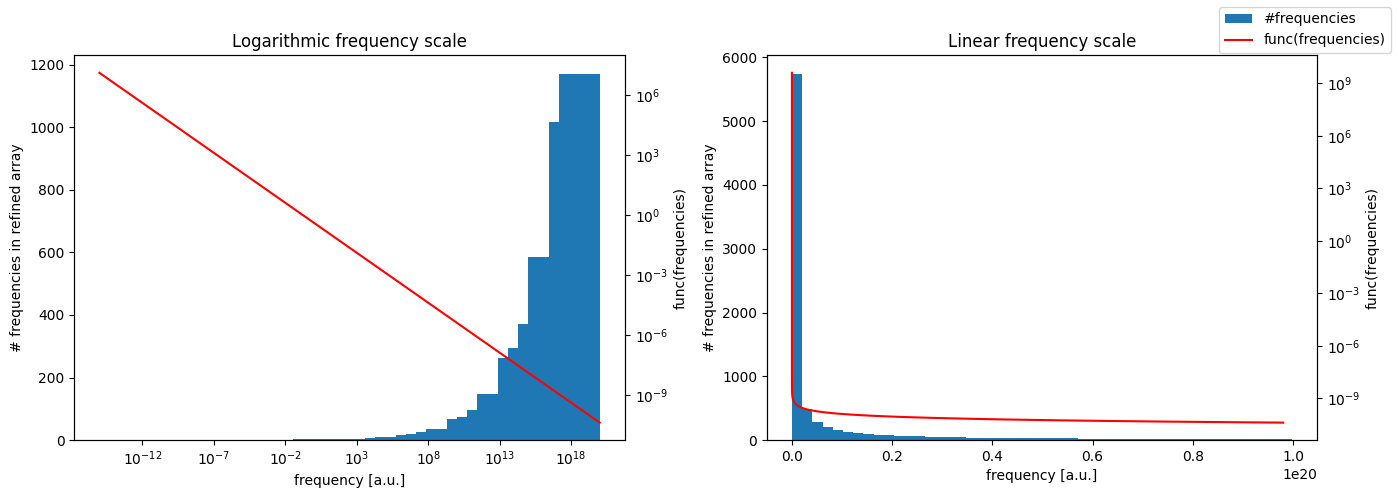

In [7]:
print(f"The final number of frequencies: {len(frequencies)}, spanning from {frequencies[0]} to {frequencies[-1]}")

fig, (ax1, ax3) = plt.subplots(1,2, figsize=(14,5))
ax2 = ax1.twinx()
ax4 = ax3.twinx()

# Logarithmic scale
ax1.set_xscale("log")
ax1.set_title("Logarithmic frequency scale")
bins = np.geomspace(frequencies[1], frequencies[-2], 50)

ax1.hist(frequencies[1:-1], bins=bins, label="#frequencies")
ax1.set_ylabel("# frequencies in refined array")
ax1.set_xlabel("frequency [a.u.]")

ax2.plot(frequencies[1:-1:100], inv_sqrt(frequencies[1:-1:100]), "r", label="func(frequencies)")
ax2.set_yscale("log")
ax2.set_ylabel("func(frequencies)")

# Linear scale
ax3.set_xscale("linear")
ax3.set_title("Linear frequency scale")
bins = np.linspace(frequencies[0], frequencies[-2], 50) 

ax3.hist(frequencies[:-1], bins=bins)
ax3.set_ylabel("# frequencies in refined array")
ax3.set_xlabel("frequency [a.u.]")

ax4.plot(frequencies[:-1:100], inv_sqrt(frequencies[:-1:100]), "r")
ax4.set_yscale("log")
ax4.set_ylabel("func(frequencies)")

fig.legend()
fig.suptitle("")
plt.tight_layout()
plt.show()

#### Plot the transform

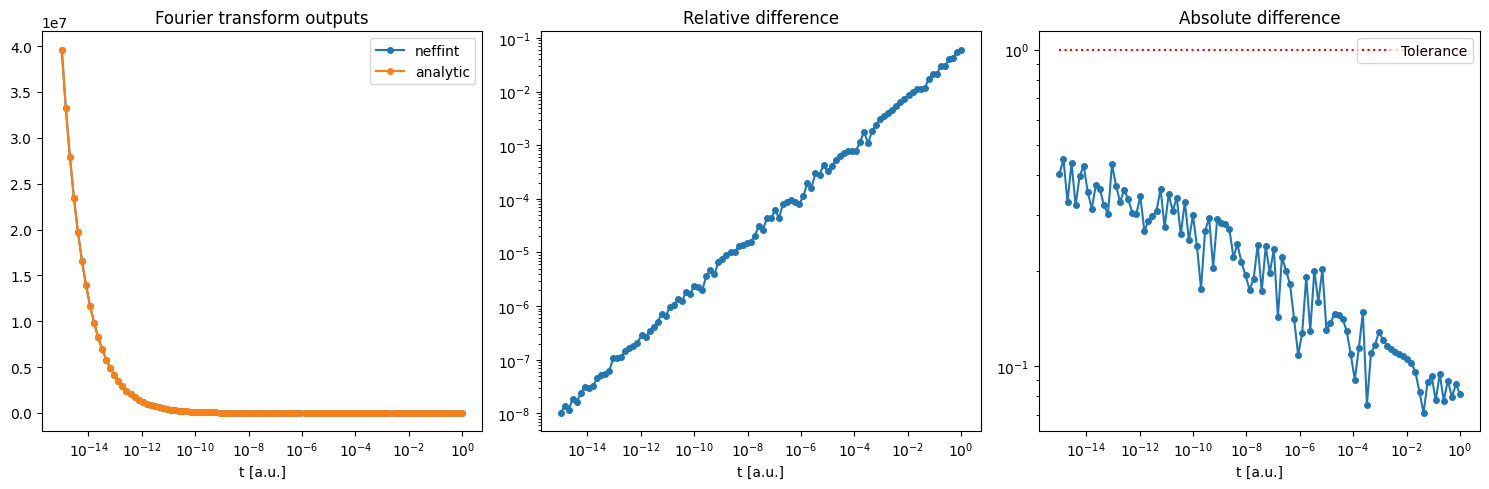

In [8]:
# Select component to plot, feel free to change np.real to e.g. np.imag, np.abs, or np.angle
f1 = np.real(transform_arr)
f2 = np.real(transform_arr_analytic)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(times, f1, "-o", markersize=4, label="neffint")
ax1.plot(times, f2, "-o", markersize=4, label="analytic")
ax1.semilogx() # Feel free to change to ax1.loglog
ax1.legend()
ax1.set_title("Fourier transform outputs")
ax1.set_xlabel("t [a.u.]")

for ax, diff in [(ax2, relative_diff), (ax3, absolute_diff)]:
    ax.plot(times, diff(f1, f2), "-o", markersize=4)
    ax.loglog()
    ax.set_title(diff.__doc__)
    ax.set_xlabel("t [a.u.]")

ax3.hlines(1e0, times[0], times[-1], "r", linestyles="dotted", label="Tolerance")
ax3.legend()

plt.tight_layout()
plt.show()

## Variation: More initial frequencies

Here, the same calculations are performed, just with more frequencies given as a starting point for the algorithm

In [9]:
# Same frequency range as before, but now with 1000 log-evenly spread over the range.
initial_frequencies_finer = np.geomspace(initial_frequencies[0], initial_frequencies[1], 1000)

frequencies_finer, func_arr_finer = nft.improve_frequency_range(
    initial_frequencies=initial_frequencies_finer,
    func=inv_sqrt,
    interpolation_error_norm=interpolation_error_norm,
    absolute_integral_tolerance=1e0, # The absolute tolerance the algorithm tries to get the error below
    step_towards_inf_factor=2, # The multiplicative step size used to scan for higher and lower frequencies to add
    bisection_mode_condition=None, # None (the default) here gives only geometric bisection when adding internal points
    max_iterations=10000,
)

transform_arr_finer = nft.fourier_integral_fixed_sampling(
    times=times,
    frequencies=frequencies_finer,
    func_values=func_arr_finer,
    pos_inf_correction_term=True,
    neg_inf_correction_term=False,
    interpolation="pchip"
)

print(f"Final number of frequencies: {len(frequencies_finer)}, spanning from {frequencies_finer[0]} to {frequencies_finer[-1]}")

Final number of frequencies: 8725, spanning from 1e-20 to 1e+20


Let's plot the new results. This time we will also compare with the transform using just the initial frequencies.

In [10]:
transform_arr_initial_frequencies_finer = nft.fourier_integral_fixed_sampling(
    times=times,
    frequencies=initial_frequencies_finer,
    func_values=inv_sqrt(initial_frequencies_finer),
    pos_inf_correction_term=True,
    neg_inf_correction_term=False,
    interpolation="pchip"
)

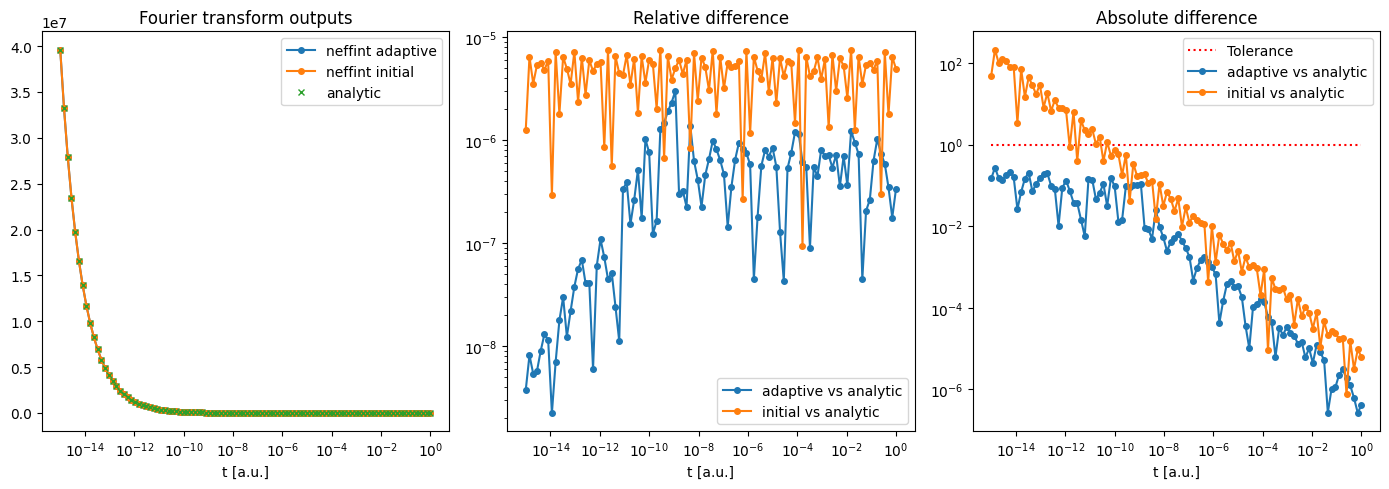

In [11]:
# Select component to plot, feel free to change np.real to e.g. np.imag, np.abs, or np.angle
f1 = np.real(transform_arr_finer)
f2 = np.real(transform_arr_initial_frequencies_finer)
f3 = np.real(transform_arr_analytic)


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,5))
ax1.plot(times, f1, "-o", markersize=4, label="neffint adaptive")
ax1.plot(times, f2, "-o", markersize=4, label="neffint initial")
ax1.plot(times, f3, "x", markersize=4, label="analytic")
ax1.semilogx() # Feel free to change to ax1.loglog
ax1.legend()
ax1.set_title("Fourier transform outputs")
ax1.set_xlabel("t [a.u.]")

ax3.hlines(1e0, times[0], times[-1], "r", linestyles="dotted", label="Tolerance")
for ax, diff in [(ax2, relative_diff), (ax3, absolute_diff)]:
    ax.plot(times, diff(f1, f3), "-o", markersize=4, label="adaptive vs analytic")
    ax.plot(times, diff(f2, f3), "-o", markersize=4, label="initial vs analytic")
    ax.loglog()
    ax.legend()
    ax.set_title(diff.__doc__)
    ax.set_xlabel("t [a.u.]")

plt.tight_layout()
plt.show()

As can be seen from the plots, the results were more accurate now that we used more initial frequencies. For example, at $t = 10^0 \text{s}$, we now get $<10^{-6}$ relative error, whereas it was close to $10^{-1}$ before. The plot also shows how the adaptive algorithm improves the frequency range given as input. When looking at the absolute error, we see that the initial frequencies gave an error above $10^0$ in the output, while the improved frequencies stay below $10^0$ over the entire time range. This is to be expected, since the tolerance was set to `1e0`.

## Variation: Bad initial frequency endpoints

The algorithm only adds points to the interior of the initial range. To demonstrate this, here is an example with a much shorter initial range.

In [12]:
initial_frequencies_short = (1e10, 1e20) # Original was (1e-10, 1e20)

frequencies_short, func_arr_short = nft.improve_frequency_range(
    initial_frequencies=initial_frequencies_short,
    func=inv_sqrt,
    interpolation_error_norm=interpolation_error_norm,
    absolute_integral_tolerance=1e0, # The absolute tolerance the algorithm tries to get the error below
    step_towards_inf_factor=2, # The multiplicative step size used to scan for higher and lower frequencies to add
    bisection_mode_condition=None, # None (the default) here gives only geometric bisection when adding internal points
    max_iterations=10000,
)

transform_arr_short = nft.fourier_integral_fixed_sampling(
    times=times,
    frequencies=frequencies_short,
    func_values=func_arr_short,
    pos_inf_correction_term=True,
    neg_inf_correction_term=False,
    interpolation="pchip"
)

print(f"Final number of frequencies: {len(frequencies_short)}, spanning from {frequencies_short[0]} to {frequencies_short[-1]}")

Final number of frequencies: 7261, spanning from 10000000000.0 to 1e+20


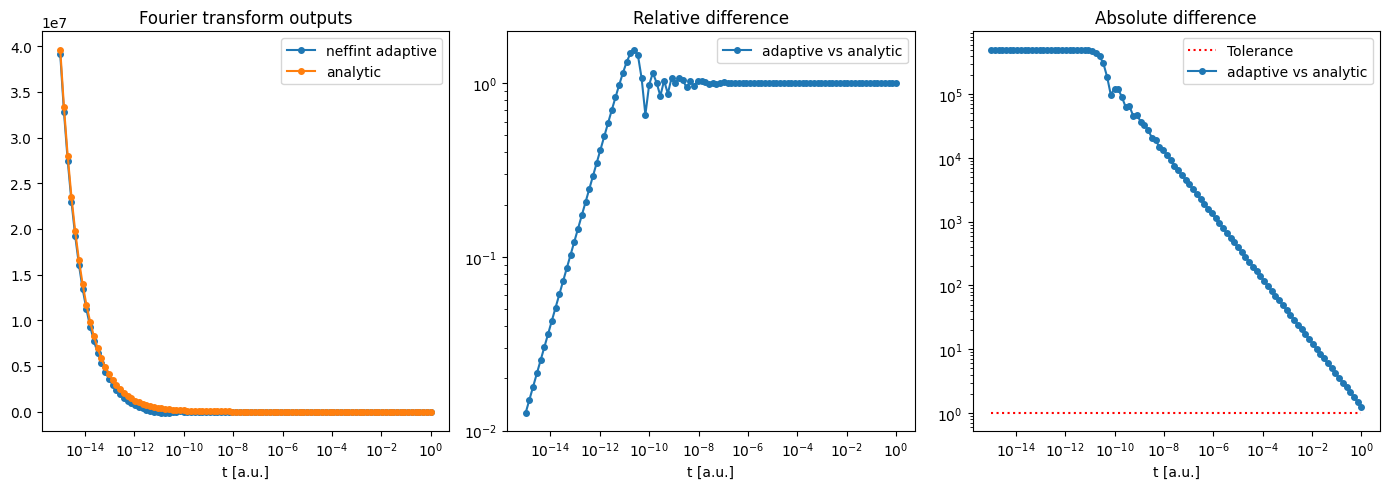

In [13]:
# Select component to plot, feel free to change np.real to e.g. np.imag, np.abs, or np.angle
f1 = np.real(transform_arr_short)
f2 = np.real(transform_arr_analytic)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,5))
ax1.plot(times, f1, "-o", markersize=4, label="neffint adaptive")
ax1.plot(times, f2, "-o", markersize=4, label="analytic")
ax1.semilogx() # Feel free to change to ax1.loglog
ax1.legend()
ax1.set_title("Fourier transform outputs")
ax1.set_xlabel("t [a.u.]")

ax3.hlines(1e0, times[0], times[-1], "r", linestyles="dotted", label="Tolerance")
for ax, diff in [(ax2, relative_diff), (ax3, absolute_diff)]:
    ax.plot(times, diff(f1, f3), "-o", markersize=4, label="adaptive vs analytic")
    ax.loglog()
    ax.legend()
    ax.set_title(diff.__doc__)
    ax.set_xlabel("t [a.u.]")

plt.tight_layout()
plt.show()

Here, we see that the results are much worse than both previous rounds. The absolute error is even above the tolerance of $10^0$ for the entire range! It is therefore advisable to experiment to find a suitable range of initial frequencies. Remember that both $0$ and $\pm \infty$ are valid entries into the initial frequency range. The only things to note is that `func` should give finite outputs for all frequencies in the initial range, and that, as mentioned above, adding infinities can end up hurting accuracy instead of helping it.

## Some remarks

Here are some other remarks about how the algorithm selects new frequencies:

### Bisection mode

Through the argument `bisection_mode_condition`, it is possible to choose between bisecting frequency intervals using a linear bisection or a geometric bisection*.

Using the linear bisection, the midpoint frequency in the interval between $\omega_k$ and $\omega_{k+1}$ is given by:

$$
\omega_{k, k+1} = \frac{\omega_k + \omega_{k+1}}{2},
$$

whereas using the geometric mean, the midpoint is

$$
\omega_{k, k+1} = \operatorname{sign}(\omega_k) \sqrt{\omega_k \omega_{k+1}} = e^\frac{\ln(\omega_k) + \ln(\omega_{k+1})}{2}.
$$

The geometric midpoint can be useful as it gives a more even spacing on a logscale frequency grid.

Which form of bisection is used for a given interval is selected using the `bisection_mode_condition` parameter.
This accepts a callable that takes in an array of frequencies and outputs an array of booleans.
A value of `True` in the output array indicates that the interval _following_ that frequency should be bisected linearly.

As an example, in order to use a linear bisection for all frequencies between `1e8` and `1e9`, define the following

```python
def linear_mask_1e8_to_1e9(freq_interval_startpoints: np.ndarray) -> np.ndarray:
    return 1e8 < freq_interval_startpoints & freq_interval_startpoints < 1e9
```
and set `bisection_mode_condition=linear_mask_1e8_to_1e9`.

The default argument (`None`) makes the algorithm use logarithmic bisection for all frequency intervals not containing 0.

Since the geometric midpoint is undefined for intervals containing 0, Neffint will always use linear bisection for such intervals,
regardless of what `bisection_mode_condition` is set to.

The difference between the two midpoint types are illustrated here:

![Linscale-illustration](./_example_figures/linscale_bisection_mode_comparison.png)
![Logscale-illustration](./_example_figures/logscale_bisection_mode_comparison.png)


*The geometric bisection could also be called logarithmic, but to avoid confusion with the logarithmic mean, which is something different: https://en.wikipedia.org/wiki/Logarithmic_mean

### Semi-infinite and infinite ranges

When computing Fourier integrals, one is usually interested in the integral computed over the one of the ranges $(0,\infty)$ or $(-\infty, \infty)$, and not with final endpoints. The adaptive algorithm of Neffint provides two ways to accomodate this.

The first is to use the `pos_inf_correction_term` and `neg_inf_correction_term` parameters of `neffint.fourier_integral_adaptive`, which is passed on to the call of `neffint.fourier_integral_fixed_sampling`. This adds a correction term computed from the first two terms of the Taylor expansion from $\omega_{min}$ or $\omega_{max}$.

The second is to set $\pm \infty$ as (one or both of the) endpoints of the initial frequency range. In this case, the algorithm will gradually add higher and higher frequencies. These are computed by "bisecting" the interval $(\omega_{N-1}, \infty)$, where $\omega_{N-1}$ is the final frequency, by giving it the "midpoint" frequency $c_\infty\omega_{N-1}$, where $c_\infty$ is a constant set by the `step_towards_inf_factor` parameter. This is equivalent to bisecting the interval $(\omega_{N-1}, c_\infty^2\omega_{N-1})$ geometrically, and this interval is therefore used for the error integration as well.